# Directed Search

This notebook processes the output from the EMA workbench's generative algorithm, which identifies optimal policies within each of our selected scenarios of interest. The aim is to refine and reduce the discovered policies that can be tested for robustness.

Initially, we load the various output files generated by the optimizer. We then filter out any policies that are strictly dominated by others in terms of outcome performance within the same scenario. Next, we calculate and visualize key metrics to confirm that the policy search has converged. Subsequently, we conduct experiments on the identified policies under their originating scenarios to check if they meet the predefined constraints and filter the policies accordingly. Lastly, we select a subset of policies that exhibit diversity in terms of the levers they utilize.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn import preprocessing

from ema_workbench.em_framework.optimization import (
    ArchiveLogger, 
    to_problem,
    epsilon_nondominated
)
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
    Scenario,
    Policy,
    MultiprocessingEvaluator,
)
from ema_workbench.util import ema_logging


from problem_formulation import get_model_for_problem_formulation
from set_diversity import find_maxdiverse

----------------------
## 0. Imports and Setup

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

We will need `model_urban` objects for both of our problem formulations, as the optimization was run using `Urban Dikes`, but to calculate metrics of constraint, we will measure the entire outcome set (`All Dikes`).

In [3]:
# Obtain the model and steps for the 'Urban Dikes' problem formulation
model_urban, steps = get_model_for_problem_formulation('Urban Dikes')

# Convert the obtained model into an optimization problem
problem_urban = to_problem(model_urban, searchover="levers")

# Model with 13 outcomes, neccesary to apply the constraits
model_all, steps = get_model_for_problem_formulation('All Dikes')
problem_all = to_problem(model_all, searchover="levers")

### Read Results

We will use the results produced by the file [4.a. seeded_scenario_optimization.py](4.a.%20seeded_scenario_optimization.py). In order to parse and store these results, we will also read in the scenarios for which the multi-scenario optimization was run.

In [4]:
# Read Scenarios from file
scenarios_df = pd.read_csv('./output/scenarios_selected.csv')
scenarios_df = scenarios_df.set_index('Run ID')
scenarios_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
Run ID,,,,,,,,,,,,,,,,,,,
9951,36,258.411992,10.0,0.237135,86.093951,1.0,0.388962,163.931496,1.0,0.158931,32.766716,1.0,0.659580,72.927447,1.0,0.608442,1.5,3.5,4.5
595,78,64.243511,1.0,0.556926,270.912165,10.0,0.941977,203.129077,10.0,0.074396,130.978544,1.0,0.470632,123.974204,1.0,0.530415,3.5,1.5,2.5
2803,107,192.535868,1.5,0.469050,112.324509,10.0,0.928541,31.824536,1.5,0.058908,313.837261,1.5,0.341279,258.362260,1.5,0.019238,2.5,1.5,2.5
4842,70,86.182482,1.5,0.292821,249.094061,1.5,0.069144,222.699038,10.0,0.029285,44.328236,10.0,0.421806,31.385883,1.5,0.086405,2.5,1.5,1.5


In [5]:
# Convert Scenario IDs to a list
scenarios = [int(idx) for idx, row in scenarios_df.iterrows()]
scenarios

[9951, 595, 2803, 4842]

In [6]:
# Read optimization output files. For each (seed, scenario) pair, there are
# 3 files to read: results and convergence (CSVs), and archives (a tarball).
# This process seeds are sequential starting at 0, but could be adapted 
# to handle arbitrary seed numbers.

results = {}
convergences = {}
archives = {}

for scenario in scenarios:
    results[scenario] = []
    convergences[scenario] = []
    archives[scenario] = []
    for seed in range(2):
        # Results and Convergences
        fn_head = './output/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.csv'

        res = pd.read_csv(fn_head + 'results' + fn_tail, index_col=0)
        results[scenario].append(res)

        conv = pd.read_csv(fn_head + 'convergence' + fn_tail, index_col=0)
        convergences[scenario].append(conv)

        # Archives
        fn_head = './archives/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.tar.gz'
        arch = ArchiveLogger.load_archives(fn_head + 'archive' + fn_tail)
        for key, df in arch.items():
            if 'Unnamed: 0' in df.columns:
                arch[key] = arch[key].drop('Unnamed: 0', axis=1)
        archives[scenario].append(arch)


-------------------
## 1. Filtering Out Pareto-Dominated Policies

In this section, we remove any policies that are strictly inferior to other policies tested within the same scenario. These dominated policies appear in the total set because the optimizer was run with two different seeds. Since they are not valuable for further analysis (in a single-seed test, the generative algorithm would naturally disregard such dominated policies), we need to filter them out.

In [7]:
policy_sets = {}
epsilon = [100, 0.01, 100, 100, 0.01]
for scenario in scenarios:
    df = epsilon_nondominated(results[scenario], epsilon, problem_urban)
    policy_sets[scenario] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario} has {n_policies} non-dominated policies")

Scenario 9951 has 28 non-dominated policies
Scenario 595 has 72 non-dominated policies
Scenario 2803 has 317 non-dominated policies
Scenario 4842 has 230 non-dominated policies


After this step, we are left with almost 647 policies to consider going forward.

---------------------

## 2. Test Convergence of Generative Algorithm

To ensure that the generative algorithm was allowed enough generations to identify meaningful policies, we will plot various convergence metrics for each seed and scenario used in our search. This will help demonstrate that the algorithm had sufficient runtime to converge effectively.

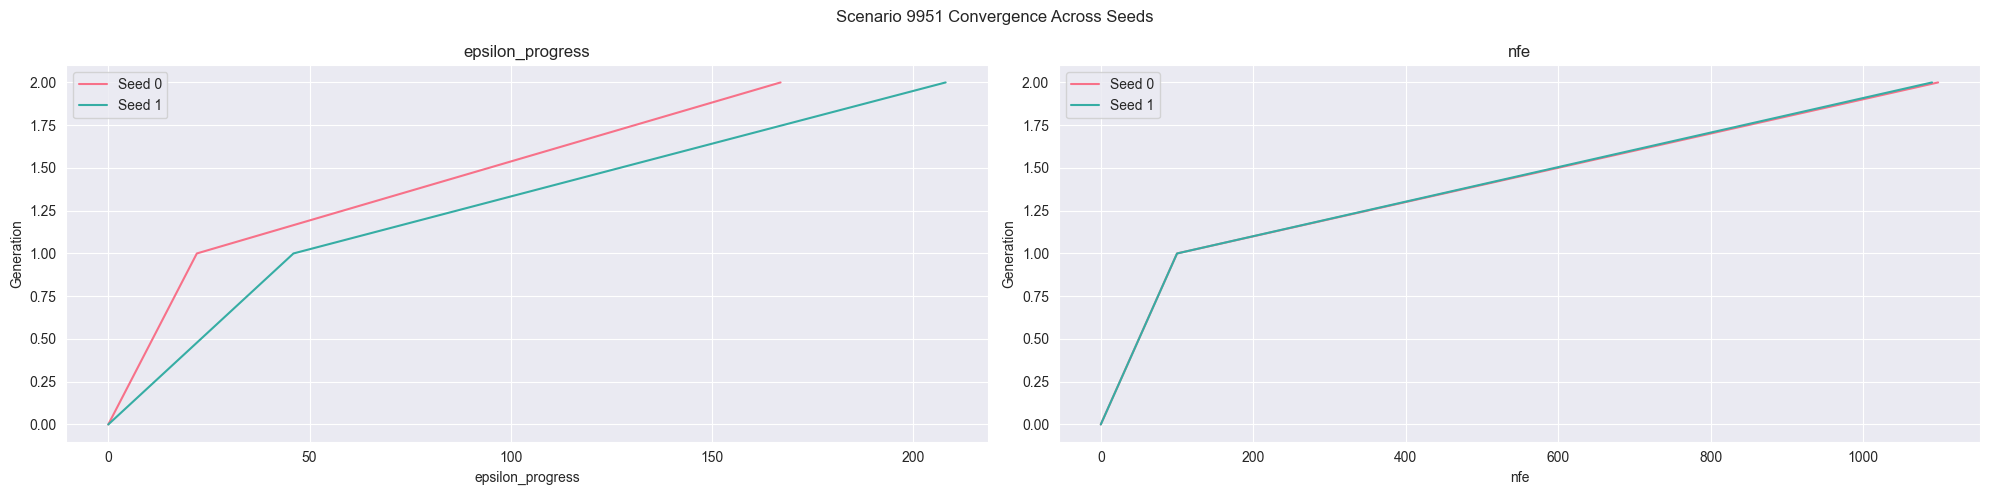

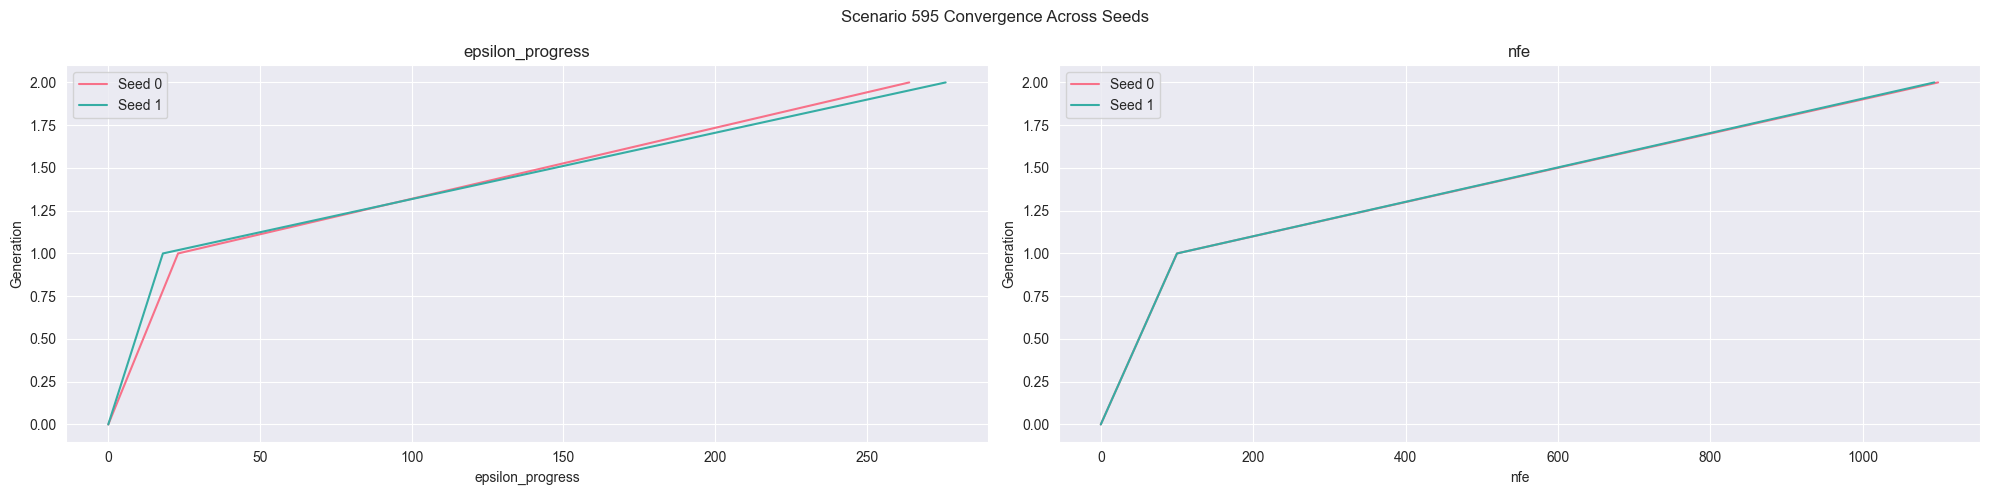

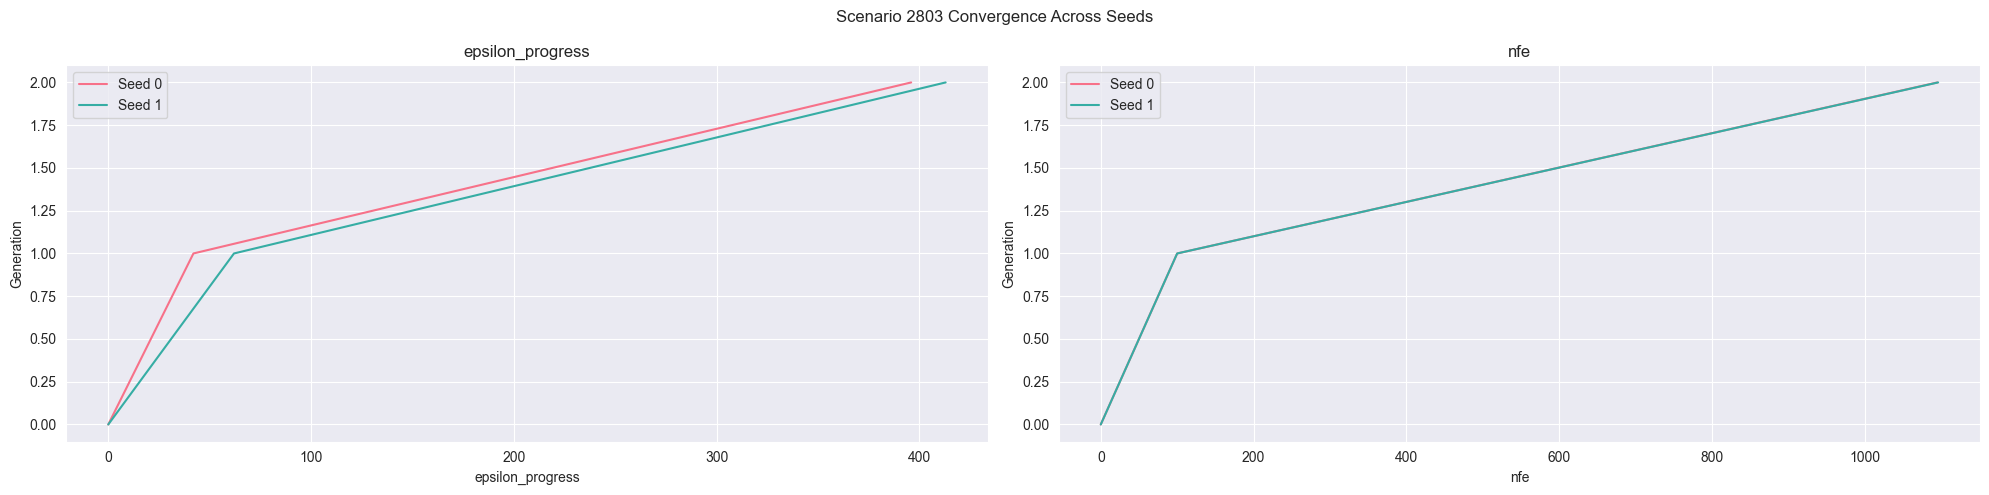

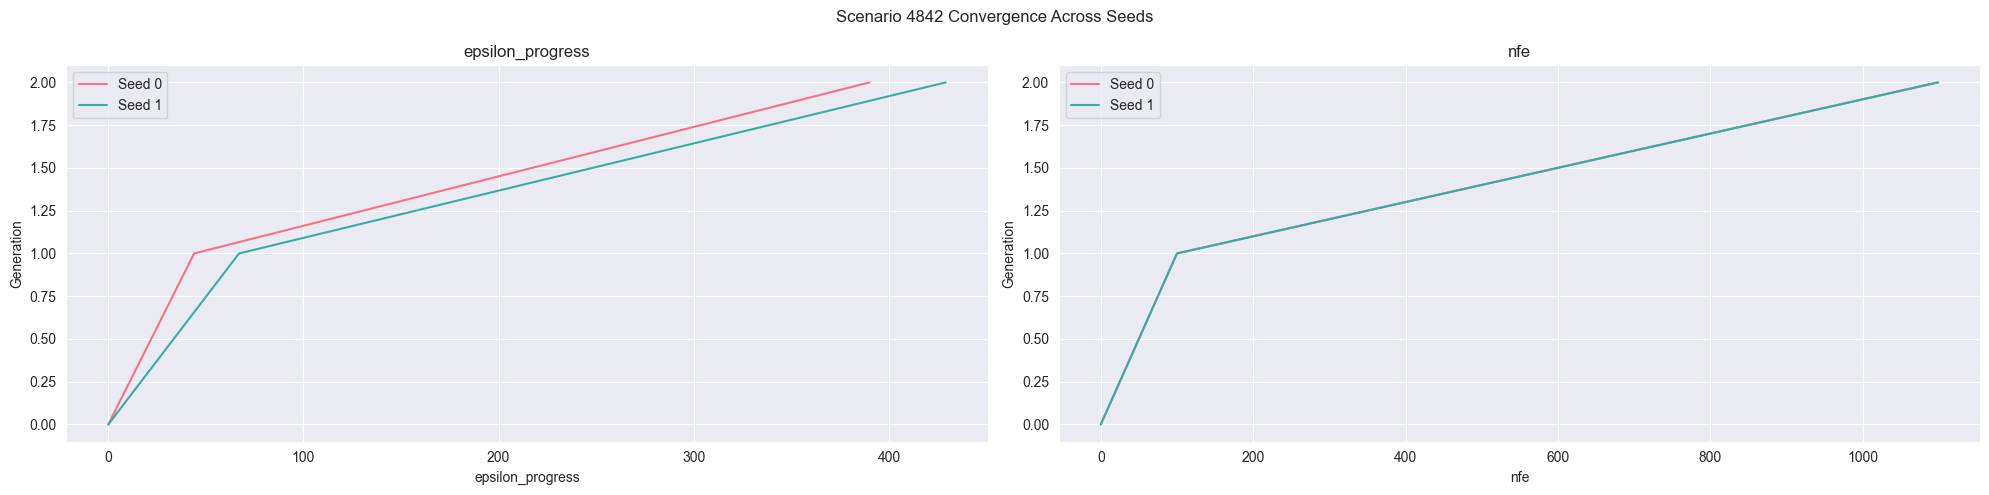

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create the img directory if it doesn't exist
if not os.path.exists('img'):
    os.makedirs('img')

# Function to plot convergence for multiple seeds in a single scenario and save the plot
def plot_convergence_multi_seed(convergence_data, scenario, seeds):
    # Use seaborn color palette for more colorful plots
    colors = sns.color_palette("husl", len(seeds))
    
    fig, axs = plt.subplots(1, len(convergence_data[0].columns), figsize=(20, 5))
    fig.suptitle(f'Scenario {scenario} Convergence Across Seeds')

    for i, column in enumerate(convergence_data[0].columns):
        for seed, color in zip(seeds, colors):
            data = convergence_data[seed]
            axs[i].plot(data[column], data.index, label=f'Seed {seed}', color=color)  # Swap x and y
        axs[i].set_ylabel('Generation')  # Change x-label to y-label
        axs[i].set_xlabel(column)        # Change y-label to x-label
        axs[i].set_title(column)
        axs[i].legend()

    plt.tight_layout()
    # Save the plot
    plt.savefig(f'img/scenario_{scenario}_convergence.png')
    # Show the plot
    plt.show()
    plt.close()

# Example of how to use the function
for scenario in scenarios:
    # Collect convergence data for all seeds in this scenario
    convergence_data = {seed: convergences[scenario][seed] for seed in range(2)}
    plot_convergence_multi_seed(convergence_data, scenario, range(2))



Due to computational constraints, we limited the iterations to only two seeds. Based on the epsilon progress graph, Scenario 596 emerged as the best policy. However, we recommend conducting additional iterations to obtain more reliable results.

----------------------------
## 3. Filter Policies by Whether They Satisfy the Constraints

As a transport company, our objective is to ensure the damage probability across all dikes is managed effectively. While we are particularly concerned with urban dikes, specifically Dike Rings 3 and 5, we also need to maintain an acceptable level of protection across all dikes. To achieve this, we must apply certain constraints to filter our policies, ensuring they meet our operational goals. These constraints are derived from our understanding of the situation and our internal requirements.

The implementation of our constraints includes the following steps:

1. Model Setup: We begin by setting up our model to focus on urban dikes and defining the problem formulation to guide our search for optimal policies.
2. Scenario Selection: We read the selected scenarios from a pre-saved file and identify the specific scenarios we need to evaluate.
3. Optimization Output: We gather the results, convergences, and archives from the optimization process for each scenario and seed. This involves reading multiple output files and preparing the data for further analysis.
4. Policy Evaluation: We apply an epsilon-nondominated filter to identify non-dominated policies for each scenario, ensuring we only consider the most effective policies.
5. Applying Constraints: We evaluate the selected policies against our predefined constraints. These constraints are designed to ensure the damages and deaths in urban dikes are kept within acceptable limits compared to both the "Do Nothing" case and the industrial farmers' dikes. Specifically, the ratios of damages and deaths in Dike Ring 4 to those in Dike Rings 3 and 5 should not be worse than the baseline, and the ratios to those in Dike Rings 1 and 2 should not exceed 80% of the baseline values.
6. Collecting Satisficing Policies: We filter the policies to keep only those that satisfy all the constraints, ensuring they meet our operational goals and provide a balanced level of protection across all dikes.

By following this approach, we can confidently select policies that offer robust protection for the IJssel River region, particularly focusing on the critical urban areas while maintaining overall safety and operability for our transport operations.

### Generating & Running Experiments

To apply these constraints, we need to conduct experiments with the IJssel River model to assess how these policies perform under their respective originating scenarios. This involves creating Policy and Scenario objects for the EMA Workbench, which will be used to execute these experiments.

In [10]:
import pandas as pd
import numpy as np
from ema_workbench.em_framework.optimization import ArchiveLogger, to_problem, epsilon_nondominated
from ema_workbench import ema_logging
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

# Model setup
model, steps = get_model_for_problem_formulation('Urban Dikes')
problem = to_problem(model, searchover="levers")

# Read scenarios from file
scenarios_df = pd.read_csv('./output/scenarios_selected.csv')
scenarios_df = scenarios_df.set_index('Run ID')
scenarios = [int(idx) for idx, row in scenarios_df.iterrows()]

# Read optimization output files
results = {}
convergences = {}
archives = {}

for scenario in scenarios:
    results[scenario] = []
    convergences[scenario] = []
    archives[scenario] = []
    for seed in range(2):
        # Results and Convergences
        fn_head = './output/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.csv'

        res = pd.read_csv(fn_head + 'results' + fn_tail, index_col=0)
        results[scenario].append(res)

        conv = pd.read_csv(fn_head + 'convergence' + fn_tail, index_col=0)
        convergences[scenario].append(conv)

        # Archives
        fn_head = './archives/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.tar.gz'
        arch = ArchiveLogger.load_archives(fn_head + 'archive' + fn_tail)
        for key, df in arch.items():
            if 'Unnamed: 0' in df.columns:
                arch[key] = arch[key].drop('Unnamed: 0', axis=1)
        archives[scenario].append(arch)

policy_sets = {}
epsilon = [100, 0.01, 100, 100, 0.01]
for scenario in scenarios:
    df = epsilon_nondominated(results[scenario], epsilon, problem)
    policy_sets[scenario] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario} has {n_policies} non-dominated policies")

# Apply constraints and collect satisficing policies
STRICTNESS = 1.25  # acceptability vs. Industrialized Farmers (1.25 = 1/0.8)
satisficing_policies = []

# Assuming you have a way to map scenarios to policies, for example:
policies_to_evaluate = {scenario: policy_sets[scenario] for scenario in scenarios}

for scenario in scenarios:
    for seed in range(2):
        experiments, outcomes = results[scenario][seed], results[scenario][seed]
        outcomes = pd.DataFrame(outcomes)

        # Calculate ratios of interest
        outcomes['Urban Damages Ratio'] = (
            (outcomes['A3ExpectedAnnualDamage'] 
               + outcomes['A5ExpectedAnnualDamage'])
            / (outcomes['Total_Expected_Annual_Damage'])
        )

        outcomes['Urban Deaths Ratio'] = (
            (outcomes['A3ExpectedNumberofDeaths']
               + outcomes['A5ExpectedNumberofDeaths'])
            / (outcomes['Total_Expected_Number_of_Deaths'])
        )

        # Extract the Base Case ("Do Nothing" policy)
        base_case = outcomes.iloc[len(outcomes)-1, :]
        outcomes = outcomes.iloc[:len(outcomes)-1, :]

        # Determine whether ratios have been exceeded
        outcomes['Urban Damages Ratio Exceeded'] = \
                np.where(outcomes['Urban Damages Ratio']
                         > base_case['Urban Damages Ratio'],
                         True,
                         False)
        outcomes['Urban Deaths Ratio Exceeded'] = \
                np.where(outcomes['Urban Deaths Ratio']
                         > base_case['Urban Deaths Ratio'],
                         True,
                         False)

        # Keep rows that satisfy ALL constraints (all must be False)
        constraint_cols = [
            'Urban Damages Ratio Exceeded',
            'Urban Deaths Ratio Exceeded',
            ]
        satisficing_policy_outcomes = outcomes[outcomes[constraint_cols].sum(axis=1) == 0]

     

Scenario 9951 has 28 non-dominated policies
Scenario 595 has 72 non-dominated policies
Scenario 2803 has 317 non-dominated policies
Scenario 4842 has 230 non-dominated policies


Scenario 2803, with 317 non-dominated policies, offers the most policy options for achieving desired outcomes, followed by Scenario 4842, Scenario 595, and Scenario 9951, indicating that Scenario 2803 provides the highest flexibility for robust decision-making.

In [11]:
satisficing_policy_outcomes.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A5ExpectedAnnualDamage,A5ExpectedNumberofDeaths,A5DikeInvestmentCosts,Total_Dike_Investment,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,Urban Damages Ratio,Urban Deaths Ratio,Urban Damages Ratio Exceeded,Urban Deaths Ratio Exceeded
0,1,1,1,1,1,0,1,0,1,0,...,2.736482e+08,0.029983,2.770324e+08,5.270373e+09,5.971367e+08,0.096398,0.888881,0.911516,False,False
1,1,0,1,0,1,0,0,0,1,0,...,3.529790e+07,0.003004,2.535040e+08,1.061732e+10,7.028204e+07,0.006724,0.502232,0.446748,False,False
3,1,1,0,1,1,1,1,1,0,0,...,0.000000e+00,0.000000,1.152153e+09,1.286178e+10,0.000000e+00,0.000000,NaN,NaN,False,False
4,1,1,1,0,1,1,1,1,0,0,...,0.000000e+00,0.000000,9.877689e+08,1.222655e+10,3.331187e+07,0.006067,0.839103,0.903470,False,False
5,0,1,1,1,0,0,1,0,1,1,...,3.583856e+07,0.003613,1.407590e+08,6.397619e+09,4.114162e+07,0.004186,0.871102,0.863049,False,False


In [12]:
   for idx, row in satisficing_policy_outcomes.iterrows():
            policy = policies_to_evaluate[scenario].iloc[idx].copy()
            policy['Policy Name'] = f"s{scenario}_p{idx}"  # Add a name for the policy
            for col in outcomes.columns:
                policy[col] = row[col]
            satisficing_policies.append(policy)

# Combine all satisficing policies into a single DataFrame
satisficing_policies_df = pd.DataFrame(satisficing_policies).reset_index(drop=True)

# Save satisficing policies with all outcomes to a CSV file
satisficing_policies_df.to_csv('./output/_satisficing_policies.csv', index=False)

# Load the newly created satisficing policies file to compare with the provided one
# new_satisficing_policies = pd.read_csv('./output/_satisficing_policies.csv')

# Display the first few rows of the new satisficing policies and the provided policies for comparison
satisficing_policies_df.head()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A5ExpectedNumberofDeaths,A5DikeInvestmentCosts,Total_Dike_Investment,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,Policy Name,Urban Damages Ratio,Urban Deaths Ratio,Urban Damages Ratio Exceeded,Urban Deaths Ratio Exceeded
0,1,1,1,1,1,0,1,0,1,0,...,0.029983,2.770324e+08,5.270373e+09,5.971367e+08,0.096398,s4842_p0,0.888881,0.911516,False,False
1,1,0,1,0,1,0,0,0,1,0,...,0.003004,2.535040e+08,1.061732e+10,7.028204e+07,0.006724,s4842_p1,0.502232,0.446748,False,False
2,1,1,0,1,1,1,1,1,0,0,...,0.000000,1.152153e+09,1.286178e+10,0.000000e+00,0.000000,s4842_p3,NaN,NaN,False,False
3,1,1,1,0,1,1,1,1,0,0,...,0.000000,9.877689e+08,1.222655e+10,3.331187e+07,0.006067,s4842_p4,0.839103,0.903470,False,False
4,0,1,1,1,0,0,1,0,1,1,...,0.003613,1.407590e+08,6.397619e+09,4.114162e+07,0.004186,s4842_p5,0.871102,0.863049,False,False


In [13]:
print(f'{satisficing_policies_df.shape[0]} policies satisfy the constraints.')

125 policies satisfy the constraints.


In [15]:
satisficing_policies_df.to_csv('./output/satisficing_policies.csv', index=False)

--------------------------

## 4. Filter for a Diverse Set of Policies

Having identified the complete set of policies that satisfy our transport company's requirements, the next step is to narrow this down to a diverse set of 50 policies. We will achieve this by selecting policies that exhibit high diversity in lever differences. To accomplish this, we will generate 100,000 samples of possible sets of 50 policies, calculate a lever diversity score for each set, and select the set with the highest score.

In [16]:
policies_df = pd.read_csv('./output/satisficing_policies.csv')

In [17]:
random.seed(1361)

# Create ID list to select policy IDs from
n_pols = policies_df.shape[0]
indices = []
for idx, row in policies_df.iterrows():
    indices.append(idx)

# Randomly create sets of 50 policies (policy IDs)
combinations = []
for _ in range(100000):
    c = random.sample(indices, 50)
    combinations.append(tuple(c))

In [18]:
# Separate the policy levers from other information captured about those policies
policies_levers = policies_df[[L.name for L in model_urban.levers]]

# Normalize each policy lever
min_max_scaler = preprocessing.MinMaxScaler()
levers_scaled = min_max_scaler.fit_transform(policies_levers)

# Calculate normalized distances within the policy sets, and assign diversity scores
distances = squareform(pdist(levers_scaled))
policy_set_diversities = find_maxdiverse(distances, combinations)
policy_set_diversities.sort(key=lambda entry:entry[0], reverse=True)


In [19]:
# Select the most diverse set (in terms of Policy IDs)
most_diverse = policy_set_diversities[0]
most_diverse_set = list(most_diverse[1])
print(most_diverse_set)
assert(len(most_diverse_set) == 50)

[124, 104, 42, 110, 108, 23, 67, 121, 103, 62, 43, 71, 47, 51, 46, 26, 68, 102, 105, 14, 27, 122, 18, 100, 119, 70, 19, 101, 45, 86, 113, 111, 117, 63, 97, 58, 92, 8, 28, 11, 37, 75, 17, 13, 116, 76, 65, 30, 112, 16]


The most diverse set of 50 policies, based on lever differences, has been identified and consists of policy IDs: [124, 104, 42, 110, 108, 23, 67, 121, 103, 62, 43, 71, 47, 51, 46, 26, 68, 102, 105, 14, 27, 122, 18, 100, 119, 70, 19, 101, 45, 86, 113, 111, 117, 63, 97, 58, 92, 8, 28, 11, 37, 75, 17, 13, 116, 76, 65, 30, 112, 16], ensuring a robust and varied approach to policy evaluation.

In [20]:
# Find the policies that match these IDs
diverse_policies = policies_df.iloc[most_diverse_set]
diverse_policies.head(3)

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A5ExpectedNumberofDeaths,A5DikeInvestmentCosts,Total_Dike_Investment,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,Policy Name,Urban Damages Ratio,Urban Deaths Ratio,Urban Damages Ratio Exceeded,Urban Deaths Ratio Exceeded
124,1,1,1,0,0,1,0,0,0,1,...,0.014015,8.006286e+07,1.596250e+10,1.667927e+08,0.022842,s4842_p206,0.967185,0.966601,False,False
104,0,0,1,1,1,0,0,0,1,1,...,0.038321,1.614717e+08,3.515979e+09,9.249784e+07,0.072888,s4842_p168,0.607674,0.576371,False,False
42,0,1,0,0,1,0,1,0,0,1,...,0.002249,1.662079e+08,8.275183e+09,3.463248e+07,0.004561,s4842_p63,0.941012,0.950662,False,False


In [21]:
# Save to file
diverse_policies.to_csv('./output/policies__constraints_filtered__diverse.csv', index=False)